In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def blocking_cv(x,temperatura, n = 1000):
    x = np.array(x)
    n0 = int(len(x)/n)
    cvs = np.zeros(n0)
    for idx in range(n0):
        e0 = x[idx*n:(idx+1)*n]
        e0sq = np.power(e0,2)
        cvs[idx] = (np.mean(e0sq)-np.mean(e0)**2)/(temperatura*temperatura)
    return (np.mean(cvs),np.sqrt(np.mean(np.power(cvs,2))-np.mean(cvs)**2))

def bootstrap_cv(x, temperatura, n=100):
    x = np.array(x)
    cvs = np.zeros(n)
    for iteration in range(n):
        x_resampled = np.random.choice(x,len(x))
        cvs[iteration] = (np.mean(np.power(x_resampled,2))-np.mean(x_resampled)**2)/(temperatura**2)

    return (np.mean(cvs),np.sqrt(np.mean(np.power(cvs,2))-np.mean(cvs)**2))

def process_data(fileRoot,numFiles,nSpins):  
    e_mean = np.zeros(numFiles)
    m_mean = np.zeros(numFiles)
    cv_mean = np.zeros(numFiles)
    cv_mean_err = np.zeros(numFiles)
    corr_mean = np.zeros((6,numFiles))
    amount = 0

    for idx2 in range(numFiles):
        procesos_df = pd.read_csv(fileRoot+str(idx2)+".csv",delimiter="\t", skiprows = 1, header = None,names = ['Energia', 'Magnetizacion', 'Temperatura', 'Corr1','Corr2','Corr3','Corr4','Corr5','Corr6'])
        temp_list = sorted(list(procesos_df["Temperatura"].value_counts().index))
        print(fileRoot,idx2,'           ',end = '\r')
        for idx,t in enumerate(temp_list):
            e = np.array(procesos_df[procesos_df["Temperatura"] == t]["Energia"].to_list())
            m = np.array(procesos_df[procesos_df["Temperatura"] == t]["Magnetizacion"].to_list())
            corrs = np.zeros(6)
            for corrI in range(1,7):
                corrs[corrI-1] = np.sum(np.array(procesos_df[procesos_df["Temperatura"] == t]["Corr"+str(corrI)].to_list()))
            corr_mean[:,idx] += corrs
            e_mean[idx] += np.sum(e) 
            m_mean[idx] += np.sum(m)
            cvs =  blocking_cv(e,t,10000)
            cv_mean[idx] += cvs[0]
            cv_mean_err[idx] += cvs[1]
        amount += len(e)
    return (corr_mean/(amount),e_mean/(nSpins*amount),m_mean/(nSpins*amount),cv_mean/(numFiles*nSpins),cv_mean_err/(numFiles*nSpins),temp_list)

In [2]:
corr64,e64,m64,cv64,cverr64, t64 = process_data("../PT-Data/0Field/DatosN64Proceso",50,24*64)
#corr1, e1,m1,cv1,cverr1, t1 = process_data("../PT-Data/0Field/DatosN1Proceso",50,24)
#corr8, e8,m8,cv8,cverr8, t8 = process_data("../PT-Data/0Field/DatosN8Proceso",50,24*8)


In [81]:
corr8[0,:] = 1


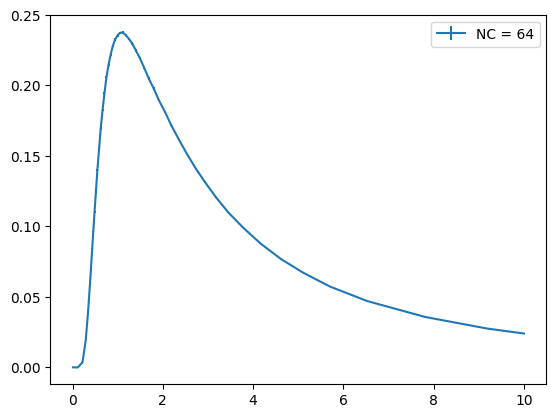

In [3]:
#plt.errorbar(np.array(t1),cv1,cverr1, label = 'NC = 1')
#print(t1)
#plt.errorbar(np.array(t8),cv8,cverr8, label = 'NC = 8')
plt.errorbar(np.array(t64),cv64,cverr64, label = 'NC = 64')
# print(t64)
plt.legend()
plt.show()

# plt.plot(np.array(t1),e1, label = 'NC = 1')
# plt.plot(np.array(t8),e8, label = 'NC = 8')
#plt.plot(np.array(t64),e64, label = 'NC = 64')
# plt.legend()
# plt.show()

# plt.plot(np.array(t1),m1, label = 'NC = 1')
# plt.plot(np.array(t8),m8, label = 'NC = 8')
# plt.plot(np.array(t64),m64, label = 'NC = 64')
# plt.legend()
# plt.show()


In [4]:
### Entropy calculation
from scipy.integrate import simps as simps
from scipy.integrate import trapz as trapz
def entropy(cv, temp):
    e1,e2,e3,e4 = np.log(2)-simps(cv/temp,temp,even = 'first'),np.log(2)-simps(cv/temp,temp,even = 'last'),np.log(2)-simps(cv/temp,temp,even = 'avg'),np.log(2)-simps(cv/temp,temp)
    return (e1+e2+e3+e4)/4

#print(entropy(cv1,t1))
#print(entropy(cv8,t8))
print(entropy(cv64,t64))


0.2308014932049533


In [5]:
### Workers analysis

def process_workers(fileRoot,numFiles):
    procesos_dfs = []
    for idx in range(numFiles):
        procesos_dfs.append(pd.read_csv(fileRoot+str(idx)+".csv",delimiter="\t"))
    dfs = pd.concat(procesos_dfs, join="inner")

    temp_list = sorted(list(dfs["Temperature"].value_counts().index))
    a_timeseries = []
    m_timeseries = []
    for t in temp_list:
        a_timeseries.append(np.array(dfs[dfs["Temperature"] == t]["Accepts"].to_list()))
        m_timeseries.append(np.array(dfs[dfs["Temperature"] == t]["Total"].to_list()))
    a_mean = np.sum(np.array(a_timeseries),axis = 1)
    m_mean = np.sum(np.array(m_timeseries),axis = 1)
    plt.plot(temp_list,a_mean/m_mean)
    plt.show()
    return procesos_dfs
    

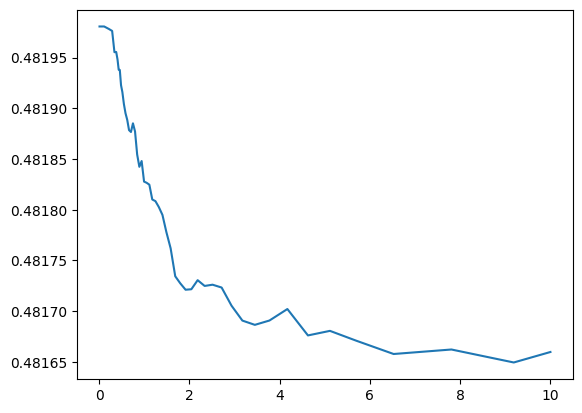

In [6]:
procesos_dfs = process_workers("../PT-Data/0Field/CountersProceso64",50)

In [7]:
m = 50
from collections import Counter
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

f_functions = []
upts = np.zeros(len(t64))
dwns = np.zeros(len(t64))
others = np.zeros(len(t64))
for n in range(m):
    print(n,'       ', end = '\r')
    ts = np.array(procesos_dfs[n].Temperature)
    labels = np.zeros(len(ts))
    currentLabel = 0
    for idx,t in enumerate(ts):
        if t == t64[0]:
            currentLabel = 1
        elif t==t64[-1]:
            currentLabel = -1
        labels[idx] = currentLabel    
        

    for idxt,t in enumerate(t64):
        upts[idxt] += np.sum((ts == t) & (labels == 1))
        dwns[idxt] += np.sum((ts == t) & (labels == -1))
        others[idxt] += np.sum((ts == t) & (labels == 0))


[1.         0.99209081 0.98966261 0.97038192 0.9388749  0.9105641
 0.89168764 0.87568473 0.8604804  0.84445425 0.82597191 0.80627137
 0.78473628 0.76267508 0.7406892  0.71836288 0.69552633 0.67334204
 0.65172849 0.63153282 0.61315794 0.59387081 0.57314831 0.55236338
 0.53176847 0.513518   0.49433668 0.47249709 0.45170876 0.42957345
 0.40923727 0.3891536  0.36903342 0.34845728 0.32904949 0.30787144
 0.28809952 0.26663645 0.246088   0.22559553 0.20394239 0.18211987
 0.15721614 0.13436745 0.11516477 0.09693321 0.07147744 0.03619692
 0.01436263 0.        ]
[0.01, 0.1805303663, 0.2825041075, 0.33820693599999996, 0.3773954749, 0.4078229356, 0.4357813838, 0.4639970021, 0.4949050548, 0.5281774, 0.5632895311, 0.59926719, 0.6362986596, 0.6744791697, 0.7142682475, 0.7560036292, 0.7996870476, 0.8454719251999999, 0.8938185238, 0.9452443939999999, 0.9999711615, 1.058122944, 1.120124688, 1.1866223, 1.257947108, 1.334025528, 1.415022041, 1.50171616, 1.5953246799999998, 1.6970525680000002, 1.8075472240

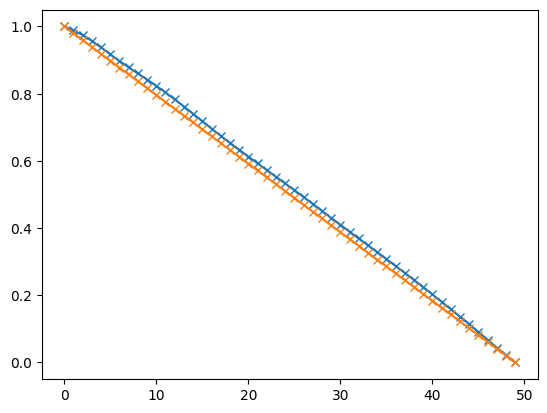

In [8]:
from scipy.stats import linregress as lr
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate



t64 = np.array(t64)
fFunc = upts/(upts+dwns)
print(fFunc)
fSmooth = fFunc
deltaTs = np.diff(t64)

for idx in range(len(fFunc)-1):
    if fFunc[idx+1] > fFunc[idx]:
        fFunc[idx+1] = fFunc[idx]

for smoothing in range(20):
    for idx in range(1,len(fFunc)-1):
        fSmooth[idx] = 0.1*fFunc[idx-1]+0.8*fFunc[idx]+0.1*fFunc[idx+1]
    fFunc = fSmooth


num_interp = 10000

t_interp = []
f_interp = []

for idxI in range(1,len(fFunc)):
    for idxJ in range(num_interp):
        t_interp.append((1.0*idxJ)/num_interp*(t64[idxI]-t64[idxI-1])+t64[idxI-1])
        f_interp.append((1.0*idxJ)/num_interp*(fFunc[idxI]-fFunc[idxI-1])+fFunc[idxI-1])

t_interp = np.array(t_interp)
f_interp = np.array(f_interp)

f_Linear = np.linspace(f_interp.max(),f_interp.min(),len(fFunc))

newTs = np.zeros(len(fFunc))
newTs[0] = t64[0]
newTs[-1] = t64[-1]
for idxI in range(1,len(fFunc)-1):
    idx = np.argmin(np.abs(f_interp-f_Linear[idxI]))
    newTs[idxI] = t_interp[idx] 

print(list(newTs))
plt.plot(fFunc,'x-')
plt.plot(f_Linear,'x-')
#plt.plot(t_interp,f_interp-f_Linear[39],)
#plt.show()

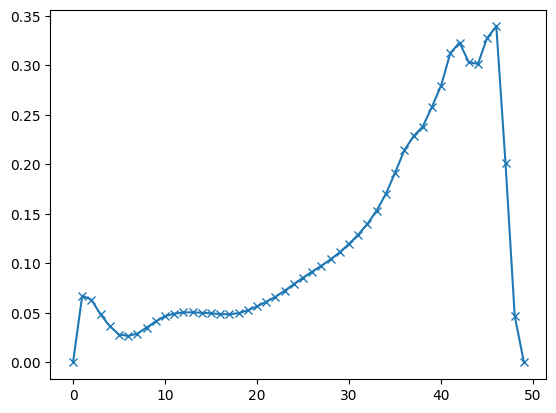

In [9]:
plt.plot(newTs-t64,'x-')
#plt.plot(t64,'x-')